# MODELING  
- Modeling a multi-layer perceptron neural network with tensoflow-keras

In [1]:
import pandas as pd

In [2]:
## load the data

df = pd.read_csv('data_modeling.csv')

df.shape

(317369, 11)

In [3]:
# check data types
df.dtypes

KUNTA                         object
Toimittajan nimi              object
Toimittajan maakoodi          object
Laskun summa ilman ALV:tä    float64
TILI                           int64
Kokonaissumma                float64
ALV-KOODI                    float64
RIVIN OSUUS VERO             float64
Kustannuspaikka               object
Tositepäivämäärä_month         int64
Tositepäivämäärä_day           int64
dtype: object

In [4]:
# convert data types for the target features into categorical
df['TILI'] = df['TILI'].astype(object)
df['ALV-KOODI'] = df['ALV-KOODI'].astype(object)

## DATA PREPARATION  
- drop missing values
    - As we discovered in the data understanding, there were some features with missing values. So, here we will simply drop the records that have missing values.
- convert categorical features to numeric
    - For machine learning modeling we need to have categorical features as numeric. For the baseline modeling we can simply use ordinal encoding for encoding categorical features as numeric.

In [5]:
from feature_engine.imputation import DropMissingData
from feature_engine.encoding import OrdinalEncoder
from feature_engine.wrappers import SklearnTransformerWrapper
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline


In [6]:
# list categorical input features
cat_features = [feat for feat in df.columns if df[feat].dtype=='O' and feat not in ['TILI', 'ALV-KOODI']]

print(cat_features)


['KUNTA', 'Toimittajan nimi', 'Toimittajan maakoodi', 'Kustannuspaikka']


In [7]:
# create pipeline for data pre-processing
preprocessing_pipeline = Pipeline(steps=[
    
    # drop records with missing values
    ('Missing', DropMissingData()),
    
    # ordinal encoding for categorical features
    ('Ordinal_Encoding', OrdinalEncoder(encoding_method='arbitrary', variables = cat_features))
    
    ] 
)

# minmax scaling the features - excluding the targets
#    ('MinMax_Scaling', SklearnTransformerWrapper(transformer=MinMaxScaler(),
#                                                 variables = [var for var in df.columns if var not in ['TILI', 'ALV-KOODI']]))

In [8]:
# fit the pipeline and transform the data

df_transformed = preprocessing_pipeline.fit_transform(df)

In [9]:
# check if any missing values
df_transformed.isnull().sum()

KUNTA                        0
Toimittajan nimi             0
Toimittajan maakoodi         0
Laskun summa ilman ALV:tä    0
TILI                         0
Kokonaissumma                0
ALV-KOODI                    0
RIVIN OSUUS VERO             0
Kustannuspaikka              0
Tositepäivämäärä_month       0
Tositepäivämäärä_day         0
dtype: int64

In [10]:
# check data for categorical features
df_transformed[cat_features].head()

,KUNTA,Toimittajan nimi,Toimittajan maakoodi,Kustannuspaikka
0,0,0,0,0
1,0,0,0,1
2,0,0,0,2
3,0,0,0,3
4,0,0,0,4


In [11]:
df_transformed.head()

,KUNTA,Toimittajan nimi,Toimittajan maakoodi,Laskun summa ilman ALV:tä,TILI,Kokonaissumma,ALV-KOODI,RIVIN OSUUS VERO,Kustannuspaikka,Tositepäivämäärä_month,Tositepäivämäärä_day
0,0,0,0,116.23,4520,132.50,114.0,16.27,0,1,8
1,0,0,0,89.78,4300,94.50,105.0,4.72,1,1,11
2,0,0,0,135.00,4340,167.40,124.0,32.40,2,1,11
3,0,0,0,149.00,4510,184.76,124.0,35.76,3,1,11
4,0,0,0,189.11,4520,215.59,114.0,26.48,4,1,12


In [12]:
# number of categories in the target feature 'TILI'
df_transformed['TILI'].nunique()

68

In [13]:
# number of categories in the target feature 'AlV-KOODI'
df_transformed['ALV-KOODI'].nunique()

21

### Tensorflow Dataset Preparation

In [14]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
from tensorflow.data import Dataset, AUTOTUNE

In [15]:
# create train and test split
train, test = train_test_split(df_transformed, test_size=0.2, random_state = 123)

train.shape, test.shape

((249052, 11), (62263, 11))

In [16]:
# seprate input features and target for the train data

train_features = train.drop(['TILI', 'ALV-KOODI'], axis = 1)
train_target_tili = train['TILI']  # target feature TILI
train_target_alvi = train['ALV-KOODI']  # target feature alvi-koodi

train_features.shape,  train_target_tili.shape, train_target_alvi.shape


((249052, 9), (249052,), (249052,))

In [17]:
# seprate input features and target for the test data

test_features = test.drop(['TILI', 'ALV-KOODI'], axis = 1)
test_target_tili = test['TILI']  # target feature TILI
test_target_alvi = test['ALV-KOODI']  # target feature alvi-koodi

test_features.shape, test_target_tili.shape, test_target_alvi.shape

((62263, 9), (62263,), (62263,))

In [18]:
## label endcoding the targets

# label encode train and test targets for target feature tili
le_tili = LabelEncoder()
train_target_tili_le = le_tili.fit_transform(train_target_tili)
test_target_tili_le = le_tili.transform(test_target_tili)

# label encode train and test targets for target feature alv-koodi
le_alvi = LabelEncoder()
train_target_alvi_le = le_alvi.fit_transform(train_target_alvi)
test_target_alvi_le = le_alvi.transform(test_target_alvi)


In [52]:
# create tensorflow dataset - train data

train_tf_dataset = Dataset.from_tensor_slices((train_features.values, (train_target_tili_le, train_target_alvi_le)))

# create tensorflow dataset - test data
test_tf_dataset = Dataset.from_tensor_slices((test_features.values, (test_target_tili_le, test_target_alvi_le)))

In [53]:
# mapping function to indicate the targets in the tensorflow datasets
def map_target(features, targets):
    return features, {"TILI":targets[0], "ALV-KOODI":targets[1]}

In [54]:
# map the function to indicate the targets
train_tf_dataset = train_tf_dataset.map(map_target)
test_tf_dataset = test_tf_dataset.map(map_target)

In [55]:
train_tf_dataset.take(1)

<TakeDataset element_spec=(TensorSpec(shape=(9,), dtype=tf.float64, name=None), {'TILI': TensorSpec(shape=(), dtype=tf.int32, name=None), 'ALV-KOODI': TensorSpec(shape=(), dtype=tf.int32, name=None)})>

In [56]:
# prepare the batches of data
train_data = train_tf_dataset.shuffle(len(train)).batch(1024).prefetch(AUTOTUNE)

test_data = test_tf_dataset.batch(1024).prefetch(AUTOTUNE)

## Tensorflow - Keras Modeling

In [57]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Normalization

In [58]:
def base_model():
    
    model = tf.keras.Sequential()

    input_layer = Input(shape=(9,))

    model.add(input_layer)

    model.add(Dense(32, activation = 'relu'))

    model.add(Dense(64, activation = 'relu'))

    model.add(Dense(128, activation = 'relu'))

    return model 


In [59]:
base_model = base_model()

In [60]:
base_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (None, 32)                320       
                                                                 
 dense_4 (Dense)             (None, 64)                2112      
                                                                 
 dense_5 (Dense)             (None, 128)               8320      
                                                                 
Total params: 10,752
Trainable params: 10,752
Non-trainable params: 0
_________________________________________________________________


In [61]:
## output layer for TILI
TILI_output = Dense(68, activation='softmax', name = 'TILI')(base_model.output)

In [62]:
## output for ALV-KOODI
ALV_output = Dense(21, activation='softmax', name = 'ALV-KOODI')(base_model.output)

In [63]:
final_model = tf.keras.Model(inputs = base_model.input,
                             outputs = (TILI_output, ALV_output) )

In [64]:
final_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 9)]          0           []                               
                                                                                                  
 dense_3 (Dense)                (None, 32)           320         ['input_2[0][0]']                
                                                                                                  
 dense_4 (Dense)                (None, 64)           2112        ['dense_3[0][0]']                
                                                                                                  
 dense_5 (Dense)                (None, 128)          8320        ['dense_4[0][0]']                
                                                                                            

In [65]:
# define the losses for each of the target outputs
losses = {
    "TILI": tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    "ALV-KOODI": tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
}


In [66]:
# compile the model
final_model.compile(loss=losses, optimizer = tf.keras.optimizers.Adam(learning_rate =  0.003), metrics = ['accuracy'])

In [67]:
# callbacks
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping


best_model = ModelCheckpoint(filepath='./best_model', save_best_only=True)

es = EarlyStopping(patience=20, min_delta=0.001, monitor = "val_loss", mode = 'min')

In [68]:
history = final_model.fit(train_data, 
                          validation_data=test_data,
                          epochs = 100,
                          callbacks = [best_model, es])

Epoch 1/100


C:\Users\ajay.byanjankar\Anaconda3\envs\mltask\lib\site-packages\keras\backend.py:5582: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


244/244 [==============================] - 11s 37ms/step - loss: 44.5920 - TILI_loss: 28.2363 - ALV-KOODI_loss: 16.3557 - TILI_accuracy: 0.1243 - ALV-KOODI_accuracy: 0.6495 - val_loss: 5.3664 - val_TILI_loss: 4.1095 - val_ALV-KOODI_loss: 1.2569 - val_TILI_accuracy: 0.1992 - val_ALV-KOODI_accuracy: 0.7006
Epoch 2/100
244/244 [==============================] - 9s 33ms/step - loss: 4.5158 - TILI_loss: 3.3783 - ALV-KOODI_loss: 1.1376 - TILI_accuracy: 0.2473 - ALV-KOODI_accuracy: 0.7289 - val_loss: 3.9695 - val_TILI_loss: 3.0768 - val_ALV-KOODI_loss: 0.8927 - val_TILI_accuracy: 0.2620 - val_ALV-KOODI_accuracy: 0.7176
Epoch 3/100
244/244 [==============================] - 8s 30ms/step - loss: 3.8340 - TILI_loss: 2.8916 - ALV-KOODI_loss: 0.9424 - TILI_accuracy: 0.2797 - ALV-KOODI_accuracy: 0.7512 - val_loss: 3.5599 - val_TILI_loss: 2.7914 - val_ALV-KOODI_loss: 0.7685 - val_TILI_accuracy: 0.2963 - val_ALV-KOODI_accuracy: 0.7555
Epoch 4/100
244/244 [==============================] - 9s 31ms/ste

244/244 [==============================] - 4s 11ms/step - loss: 2.5951 - TILI_loss: 2.2221 - ALV-KOODI_loss: 0.3731 - TILI_accuracy: 0.3905 - ALV-KOODI_accuracy: 0.8780 - val_loss: 2.4958 - val_TILI_loss: 2.1929 - val_ALV-KOODI_loss: 0.3029 - val_TILI_accuracy: 0.4083 - val_ALV-KOODI_accuracy: 0.8951
Epoch 22/100
244/244 [==============================] - 5s 15ms/step - loss: 2.5091 - TILI_loss: 2.1569 - ALV-KOODI_loss: 0.3522 - TILI_accuracy: 0.4085 - ALV-KOODI_accuracy: 0.8876 - val_loss: 2.3810 - val_TILI_loss: 2.0742 - val_ALV-KOODI_loss: 0.3068 - val_TILI_accuracy: 0.4230 - val_ALV-KOODI_accuracy: 0.9007
Epoch 23/100
244/244 [==============================] - 6s 20ms/step - loss: 2.4094 - TILI_loss: 2.0807 - ALV-KOODI_loss: 0.3288 - TILI_accuracy: 0.4212 - ALV-KOODI_accuracy: 0.8923 - val_loss: 2.3491 - val_TILI_loss: 2.0452 - val_ALV-KOODI_loss: 0.3039 - val_TILI_accuracy: 0.4260 - val_ALV-KOODI_accuracy: 0.9001
Epoch 24/100
244/244 [==============================] - 4s 13ms/step

244/244 [==============================] - 4s 10ms/step - loss: 1.9334 - TILI_loss: 1.7706 - ALV-KOODI_loss: 0.1628 - TILI_accuracy: 0.4914 - ALV-KOODI_accuracy: 0.9498 - val_loss: 2.0173 - val_TILI_loss: 1.7887 - val_ALV-KOODI_loss: 0.2286 - val_TILI_accuracy: 0.4873 - val_ALV-KOODI_accuracy: 0.9340
Epoch 42/100
244/244 [==============================] - 3s 7ms/step - loss: 2.0074 - TILI_loss: 1.8043 - ALV-KOODI_loss: 0.2031 - TILI_accuracy: 0.4851 - ALV-KOODI_accuracy: 0.9414 - val_loss: 2.4531 - val_TILI_loss: 2.0724 - val_ALV-KOODI_loss: 0.3807 - val_TILI_accuracy: 0.4343 - val_ALV-KOODI_accuracy: 0.8732
Epoch 43/100
244/244 [==============================] - 5s 17ms/step - loss: 2.0110 - TILI_loss: 1.7961 - ALV-KOODI_loss: 0.2149 - TILI_accuracy: 0.4881 - ALV-KOODI_accuracy: 0.9290 - val_loss: 1.9602 - val_TILI_loss: 1.7591 - val_ALV-KOODI_loss: 0.2010 - val_TILI_accuracy: 0.5009 - val_ALV-KOODI_accuracy: 0.9404
Epoch 44/100
244/244 [==============================] - 6s 19ms/step 

244/244 [==============================] - 5s 15ms/step - loss: 1.7929 - TILI_loss: 1.6452 - ALV-KOODI_loss: 0.1477 - TILI_accuracy: 0.5236 - ALV-KOODI_accuracy: 0.9541 - val_loss: 1.7165 - val_TILI_loss: 1.6006 - val_ALV-KOODI_loss: 0.1159 - val_TILI_accuracy: 0.5377 - val_ALV-KOODI_accuracy: 0.9669
Epoch 63/100
244/244 [==============================] - 4s 10ms/step - loss: 1.7148 - TILI_loss: 1.5981 - ALV-KOODI_loss: 0.1167 - TILI_accuracy: 0.5341 - ALV-KOODI_accuracy: 0.9639 - val_loss: 1.7855 - val_TILI_loss: 1.6625 - val_ALV-KOODI_loss: 0.1230 - val_TILI_accuracy: 0.5303 - val_ALV-KOODI_accuracy: 0.9629
Epoch 64/100
244/244 [==============================] - 3s 7ms/step - loss: 1.7523 - TILI_loss: 1.6232 - ALV-KOODI_loss: 0.1291 - TILI_accuracy: 0.5269 - ALV-KOODI_accuracy: 0.9594 - val_loss: 1.7241 - val_TILI_loss: 1.6029 - val_ALV-KOODI_loss: 0.1212 - val_TILI_accuracy: 0.5372 - val_ALV-KOODI_accuracy: 0.9634
Epoch 65/100
244/244 [==============================] - 4s 13ms/step 

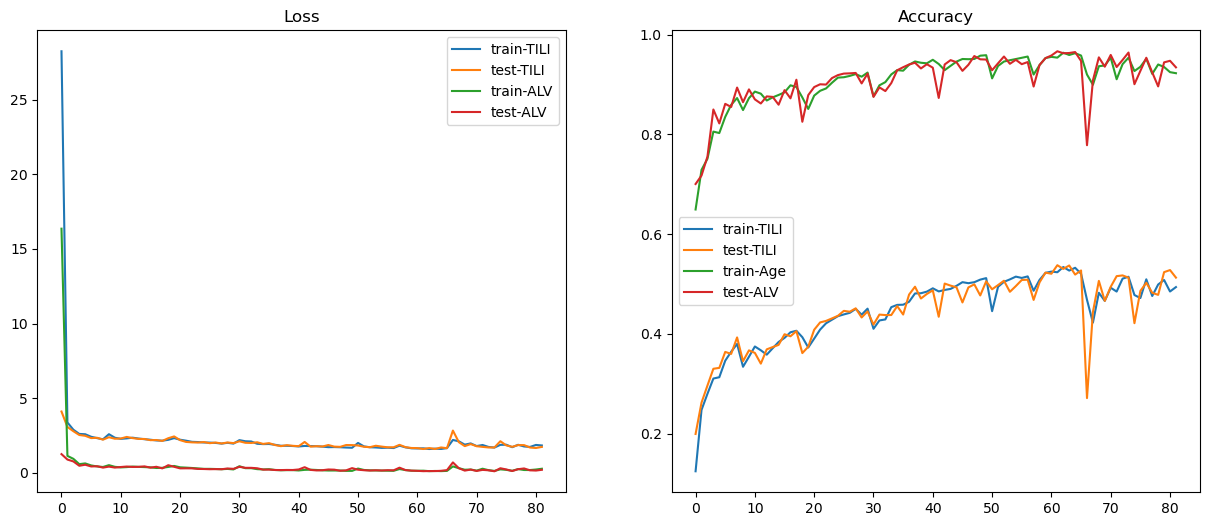

In [69]:
import matplotlib.pyplot as plt

# performance curve
plt.figure(figsize=(15,6))
epochs = history.epoch 
plt.subplot(1,2,1)
plt.plot(epochs, history.history['TILI_loss'], label = "train-TILI")
plt.plot(epochs, history.history['val_TILI_loss'], label = "test-TILI")
plt.plot(epochs, history.history['ALV-KOODI_loss'], label = "train-ALV")
plt.plot(epochs, history.history['val_ALV-KOODI_loss'], label = "test-ALV")
plt.title('Loss')
plt.legend()

plt.subplot(1,2,2)
plt.plot(epochs, history.history['TILI_accuracy'], label = "train-TILI")
plt.plot(epochs, history.history['val_TILI_accuracy'], label = "test-TILI")
plt.plot(epochs, history.history['ALV-KOODI_accuracy'], label = "train-Age")
plt.plot(epochs, history.history['val_ALV-KOODI_accuracy'], label = "test-ALV")
plt.title('Accuracy')
plt.legend()

In [71]:
# evaluate the test data

test_results = final_model.evaluate(test_data)

print(f'TILI - Loss: {test_results[0]}')
print(f'TILI - Accuracy: {test_results[2]}')
print()
print(f'ALV-KOODI - Loss: {test_results[1]}')
print(f'ALV-KOODI - Accuracy: {test_results[3]}')

61/61 [==============================] - 0s 5ms/step - loss: 1.9473 - TILI_loss: 1.7400 - ALV-KOODI_loss: 0.2073 - TILI_accuracy: 0.5128 - ALV-KOODI_accuracy: 0.9346
TILI - Loss: 1.9473037719726562
TILI - Accuracy: 0.207270085811615

ALV-KOODI - Loss: 1.7400331497192383
ALV-KOODI - Accuracy: 0.5128406882286072
